#### Importando bibliotecas

In [3]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import os
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import scipy.ndimage as ndi
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import wandb
from wandb.integration.keras import WandbMetricsLogger

#### Funções necessárias para armazenar os dados e rodar o modelo

In [4]:
# Funções para carregar as imagens já pré-processadas e calcular os labels
def calculate_label(image, threshold=0.05):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        sorted(os.listdir(path_left)), sorted(os.listdir(lesion_path_left)),
        sorted(os.listdir(path_right)), sorted(os.listdir(lesion_path_right))
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            sorted(os.listdir(img_path_left)), (os.listdir(mask_path_left)),
            sorted(os.listdir(img_path_right)), sorted(os.listdir(mask_path_right))
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(np.fliplr(data_right))
                patient_data["mask_right"].append(np.fliplr(data_msk_right))
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    return patient_data, labels_pair

In [5]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

def augment_image(img_left, img_right, mask_left, mask_right):
    """
    Gera 7 variações (exceto a imagem original) aplicando:
    - rotação 180°
    - flip vertical
    - troca de lado
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    results_left = []
    masks_left = []
    results_right = []
    masks_right = []
    
    # Todas as combinações possíveis, exceto a (False, False, False)
    for rotate in [False, True]:
        for flip in [False, True]:
            for swap in [False, True]:
                if not (rotate or flip or swap):  # pula a imagem padrão
                    continue

                l_img = img_left.copy()
                r_img = img_right.copy()
                l_mask = mask_left.copy()
                r_mask = mask_right.copy()

                if rotate:
                    l_img = rotate_180(l_img)
                    r_img = rotate_180(r_img)
                    l_mask = rotate_180(l_mask)
                    r_mask = rotate_180(r_mask)

                if flip:
                    l_img = flip_vertical(l_img)
                    r_img = flip_vertical(r_img)
                    l_mask = flip_vertical(l_mask)
                    r_mask = flip_vertical(r_mask)

                if swap:
                    l_img, r_img = r_img, l_img
                    l_mask, r_mask = r_mask, l_mask

                results_left.append(l_img)
                masks_left.append(l_mask)
                results_right.append(r_img)
                masks_right.append(r_mask)

    return results_left, results_right, masks_left, masks_right

def augment_single_image(img_left, img_right, mask_left, mask_right, rng):
    """
    Aplica uma única modificação aleatória entre:
    - rotação 180°
    - flip vertical
    - troca de lado
    - combinações entre elas
    (7 variações possíveis)
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    # Lista de todas combinações possíveis (sem a identidade)
    transformations = [
        (True, False, False),   # só rotate
        (False, True, False),   # só flip
        (False, False, True),   # só swap
        (True, True, False),    # rotate + flip
        (True, False, True),    # rotate + swap
        (False, True, True),    # flip + swap
        (True, True, True)      # rotate + flip + swap
    ]

    # Escolhe aleatoriamente uma transformação
    rotate, flip, swap = rng.choice(transformations)

    l_img = img_left.copy()
    r_img = img_right.copy()
    l_mask = mask_left.copy()
    r_mask = mask_right.copy()

    if rotate:
        l_img = rotate_180(l_img)
        r_img = rotate_180(r_img)
        l_mask = rotate_180(l_mask)
        r_mask = rotate_180(r_mask)

    if flip:
        l_img = flip_vertical(l_img)
        r_img = flip_vertical(r_img)
        l_mask = flip_vertical(l_mask)
        r_mask = flip_vertical(r_mask)

    if swap:
        l_img, r_img = r_img, l_img
        l_mask, r_mask = r_mask, l_mask

    return l_img, r_img, l_mask, r_mask

# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [6]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels = {}
    balanced_mask_left = {}
    balanced_mask_right = {}
    balanced_index_patients = {}

    # Separar os dados por conjunto (treino, validação, teste)
    train_patients = ['sub-02A13', 'sub-03C08', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16G09', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-22F14', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-51C05', 'sub-52K04', 'sub-57D04', 'sub-59G00', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    valid_patients = ['sub-00H10', 'sub-25B08', 'sub-29D03', 'sub-34J06', 'sub-56E13', 'sub-59E09', 'sub-60G06', 'sub-79H07']
    test_patients = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

    # patients = list(set(images_left.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size+0.01)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    print(len(train_patients) + len(valid_patients) + len(test_patients))
    
    class_1_left = {}
    class_0_left = {}
    class_1_right = {}
    class_0_right = {}
    class_1_mask_left = {}
    class_0_mask_left = {}
    class_1_mask_right = {}
    class_0_mask_right = {}
    class_1_coordinates = {}
    class_0_coordinates = {}

    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        index = 0
        seed = hash(patient_id) % (2**32)  # Gera uma seed única por paciente
        rng = np.random.default_rng(seed)
        
        if len(labels_pair[patient_id]) == 0:
            continue
        
        if patient_id in test_patients:
            balanced_images_left[patient_id] = images_left[patient_id]
            balanced_images_right[patient_id] = images_right[patient_id]
            balanced_labels[patient_id] = labels_pair[patient_id]
            balanced_mask_left[patient_id] = mask_left[patient_id]
            balanced_mask_right[patient_id] = mask_right[patient_id]
            continue
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 1: {class_1_count}")
        class_0_count = len(class_0_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 0: {class_0_count}")
        
        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        sampled_indices = rng.choice(len(class_0_left[patient_id]), class_1_count, replace=False)
        sampled_class_0_slices_left = [class_0_left[patient_id][i] for i in sampled_indices]
        sampled_class_0_slices_right = [class_0_right[patient_id][i] for i in sampled_indices]
        class_0_original_modified = {}
        class_0_original_modified[patient_id] = []
        class_0_opposite_modified = {}
        class_0_opposite_modified[patient_id] = []
        sampled_class_0_mask_left = [class_0_mask_left[patient_id][i] for i in sampled_indices]
        sampled_class_0_mask_right = [class_0_mask_right[patient_id][i] for i in sampled_indices]
        class_0_mask_original_modified = {}
        class_0_mask_original_modified[patient_id] = []
        class_0_mask_opposite_modified = {}
        class_0_mask_opposite_modified[patient_id] = []
        
        for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
            class_0_original_modified[patient_id].append(left_image)
            class_0_mask_original_modified[patient_id].append(left_mask)
        for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
            class_0_opposite_modified[patient_id].append(right_image)
            class_0_mask_opposite_modified[patient_id].append(right_mask)
        class_0_left = class_0_original_modified
        class_0_right = class_0_opposite_modified
        class_0_mask_left = class_0_mask_original_modified
        class_0_mask_right = class_0_mask_opposite_modified
        class_0_labels = [0] * (class_1_count)

        balanced_images_left[patient_id] = class_1_left[patient_id][:] + class_0_left[patient_id][:]
        balanced_images_right[patient_id] = class_1_right[patient_id][:] + class_0_right[patient_id][:]
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_left[patient_id] = class_1_mask_left[patient_id][:] + class_0_mask_left[patient_id][:]
        balanced_mask_right[patient_id] = class_1_mask_right[patient_id][:] + class_0_mask_right[patient_id][:]
        
        balanced_index = rng.choice(range(len(balanced_labels[patient_id])), len(balanced_labels[patient_id]), replace=False)            
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels[patient_id] = [balanced_labels[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
        balanced_index_patients[patient_id] = balanced_index
        
        if augment_factor > 1:
            augmented_left = []
            augmented_right = []
            augmented_labels = []
            
            # Gerador de números aleatórios para a aumentação
            seed = hash(patient_id) % (2**32)
            rng_aug = np.random.default_rng(seed)

            for i in range(len(balanced_labels[patient_id])):
                # Adiciona o par original
                augmented_left.append(balanced_images_left[patient_id][i])
                augmented_right.append(balanced_images_right[patient_id][i])
                augmented_labels.append(balanced_labels[patient_id][i])

                # Adiciona 'augment_factor - 1' versões aumentadas
                for _ in range(augment_factor - 1):
                    l_img_aug, r_img_aug, _, _ = augment_single_image(
                        balanced_images_left[patient_id][i],
                        balanced_images_right[patient_id][i],
                        balanced_mask_left[patient_id][i],
                        balanced_mask_right[patient_id][i],
                        rng_aug
                    )
                    augmented_left.append(l_img_aug)
                    augmented_right.append(r_img_aug)
                    augmented_labels.append(balanced_labels[patient_id][i])
            
            # Substitui os dados balanceados pelos dados aumentados
            print(f"Paciente {patient_id} aumentado de {len(balanced_labels[patient_id])} patches para {len(augmented_labels)} patches.")
            balanced_images_left[patient_id] = augmented_left
            balanced_images_right[patient_id] = augmented_right
            balanced_labels[patient_id] = augmented_labels
        
        class_1_count = len(class_1_labels)
        class_0_count = len(class_0_labels)
        print(f"Paciente {patient_id}: Total de patches no final: {class_1_count+class_0_count}")

    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_left, balanced_images_right, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients


In [7]:
# Em vez de construir uma CNN do zero, criamos uma função que carrega a VGG16 pré-treinada na ImageNet e a adapta para ser nosso extrator de características.
def build_vgg16_base(input_shape):
    """
    Constrói a base do extrator de características usando a VGG16 pré-treinada,
    adaptada para aceitar entradas de 1 canal (escala de cinza).
    """
    # 1. Define uma camada de entrada que ACEITA a sua imagem de 1 canal.
    input_tensor = Input(shape=input_shape)

    # 2. Cria uma camada que concatena (empilha) a entrada com ela mesma 3x ao longo do eixo dos canais, transformando (40, 40, 1) em (40, 40, 3).
    x = layers.Concatenate()([input_tensor, input_tensor, input_tensor])
    
    # 3. Carrega o modelo VGG16. Note que agora NÃO passamos mais 'input_shape' aqui, pois o modelo será conectado à nossa camada 'x' que já tem o formato certo.
    vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=x)

    # Congela os pesos das camadas da VGG16.
    vgg_base.trainable = False

    # 4. Cria o modelo final que encapsula essa lógica.
    model = Model(inputs=input_tensor, outputs=vgg_base.output, name="vgg16_base_grayscale")
    
    # Adicionamos uma camada para achatar a saída da VGG16 e criar o vetor de features
    # final_output = layers.GlobalAveragePooling2D()(model.output)
    final_output = layers.Flatten(name="flatten")(model.output)

    # Criamos um novo modelo que tem o GlobalAveragePooling no final
    final_model = Model(inputs=model.input, outputs=final_output)

    return final_model

# --- Buildar a Rede Siamesa ---
# A função principal agora usa a base VGG16 e uma camada Lambda para
def build_siamese_model(input_shape):
    """
    Constrói o modelo siamês completo.
    """
    input_original = Input(shape=input_shape, name="input_original")
    input_opposite = Input(shape=input_shape, name="input_opposite")

    # Criar a base VGG16 compartilhada
    feature_extractor = build_vgg16_base(input_shape)
    
    # Aplicar o mesmo extrator de características para ambas as entradas
    output_original = feature_extractor(input_original)
    output_opposite = feature_extractor(input_opposite)

    # A distância absoluta (distancia L1) é uma medida robusta de dissimilaridade.
    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([output_original, output_opposite])
    distance = layers.BatchNormalization()(distance)
    
    output = layers.Dense(128, activation='relu')(distance)
    output = layers.Dropout(0.3)(output)
    output = layers.Dense(64, activation='relu')(output)
    output = layers.Dropout(0.3)(output)

    # Camada de saída final com ativação sigmoide para classificação binária.
    final_output = layers.Dense(1, activation='sigmoid')(output)

    # Cria e compila o modelo final
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=final_output)
    
    # A compilação permanece a mesma, usando Adam e binary_crossentropy.
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model

In [8]:
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


#### Rodando funções de Pré-Processamento

In [9]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y, mask_left, mask_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data, labels_pair = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y[patient_id] = labels_pair

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1131
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 1145
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 1006
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 1113
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 1180
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 1256
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 1128
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 1206
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 1220
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 1130
Paciente sub-22F14 carregado com sucesso.
Total de recortes: 1148
Paciente sub-25B08 carregado com sucesso.
Total de recortes: 1227
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 1179
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 1102
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 1125
Paciente s

In [10]:
# Preparar dados para treino, validação e teste
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_balanced, y_valid_balanced, y_test, train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients = prepare_data_for_training(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)
train_left_balanced = (np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_right_balanced = (np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
valid_left_balanced = (np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]))
valid_right_balanced = (np.array([elemento for lista in valid_right_balanced.values() for elemento in lista]))
test_left = (np.array([elemento for lista in test_left.values() for elemento in lista]))
test_right = (np.array([elemento for lista in test_right.values() for elemento in lista]))

# Calcular média e desvio padrão APENAS no treino
mean = np.mean(train_left_balanced)
std = np.std(train_left_balanced)

# Aplicar Z-score
train_left_balanced = ((train_left_balanced - mean) / std)
train_right_balanced = ((train_right_balanced - mean) / std)
valid_left_balanced = ((valid_left_balanced - mean) / std)
valid_right_balanced = ((valid_right_balanced - mean) / std)
test_left = ((test_left - mean) / std)
test_right = ((test_right - mean) / std)

41
Paciente sub-00H10: Total de pares de recortes com label 1: 11
Paciente sub-00H10: Total de pares de recortes com label 0: 1120
Paciente sub-00H10: Total de patches no final: 22
Paciente sub-02A13: Total de pares de recortes com label 1: 93
Paciente sub-02A13: Total de pares de recortes com label 0: 1052
Paciente sub-02A13: Total de patches no final: 186
Paciente sub-03C08: Total de pares de recortes com label 1: 41
Paciente sub-03C08: Total de pares de recortes com label 0: 965
Paciente sub-03C08: Total de patches no final: 82
Paciente sub-06C09: Total de pares de recortes com label 1: 8
Paciente sub-06C09: Total de pares de recortes com label 0: 1105
Paciente sub-06C09: Total de patches no final: 16
Paciente sub-14F04: Total de pares de recortes com label 1: 8
Paciente sub-14F04: Total de pares de recortes com label 0: 1172
Paciente sub-14F04: Total de patches no final: 16
Paciente sub-16E03: Total de pares de recortes com label 1: 73
Paciente sub-16E03: Total de pares de recortes

In [11]:
# Adiciono camada de cor
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)
valid_left_balanced = np.expand_dims(valid_left_balanced, axis=-1)
valid_right_balanced = np.expand_dims(valid_right_balanced, axis=-1)
test_left = np.expand_dims(test_left, axis=-1)
test_right = np.expand_dims(test_right, axis=-1)

#### Iniciando o Wandb

In [12]:
wandb.init(project="gabrieljpanza-universidade-federal-fluminense")
wandb.run.name = "SiameseModel-Axial-VGG16"

wandb: Currently logged in as: gabrieljpanza (gabrieljpanza-universidade-federal-fluminense) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [13]:
wandb.config.epochs = 150
wandb.config.batch_size = 128
wandb.config.learning_rate = 0.001

input_shape = train_left_balanced[0].shape

#### Começando o Treinamento

Iniciando análise de similaridade com Curva ROC...
Extrator de features (base VGG16) isolado com sucesso.
Extraindo features dos patches esquerdos de validação...
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step
Extraindo features dos patches direitos de validação...
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step
Extração concluída. Shape das features: (1450, 512)
Scores de dissimilaridade calculados para todos os pares de validação.
AUC (Área Sob a Curva ROC) calculada: 0.5224


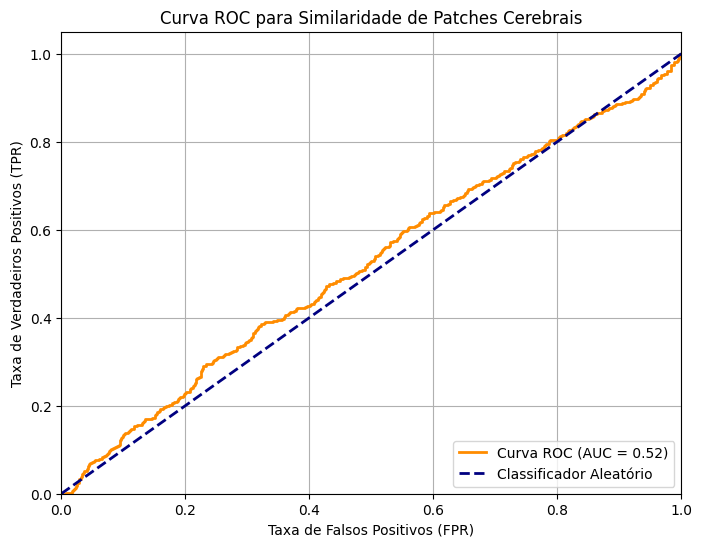


--- Ponto de Corte Ótimo Encontrado ---
Limiar de Dissimilaridade Ótimo: 0.0765
Com este limiar, teríamos:
  - Taxa de Verdadeiros Positivos (TPR): 0.3821
  - Taxa de Falsos Positivos (FPR): 0.3186


In [14]:
# --- ANÁLISE DA SIMILARIDADE À CURVA ROC ---
print("Iniciando análise de similaridade com Curva ROC...")

# --- Passo 1: Isolar o Extrator de Features (a base VGG16) ---
feature_extractor = build_vgg16_base(input_shape)
print("Extrator de features (base VGG16) isolado com sucesso.")

# --- Passo 2: Extrair os Vetores de Features dos Dados de Teste ---
print("Extraindo features dos patches esquerdos de validação...")
features_left = feature_extractor.predict(valid_left_balanced)
print("Extraindo features dos patches direitos de validação...")
features_right = feature_extractor.predict(valid_right_balanced)
print(f"Extração concluída. Shape das features: {features_left.shape}")

# --- Passo 3: Calcular a Dissimilaridade de Cosseno para cada par ---
dissimilarity_scores = []
for i in range(len(features_left)):
    # A função cosine da scipy calcula 1 - similaridade, que é exatamente a dissimilaridade
    dissimilarity = cosine(features_left[i], features_right[i])
    dissimilarity_scores.append(dissimilarity)

dissimilarity_scores = np.array(dissimilarity_scores)

true_labels = y_valid_balanced 

print("Scores de dissimilaridade calculados para todos os pares de validação.")

# --- Passo 4: Gerar a Curva ROC e Calcular a AUC ---
fpr, tpr, thresholds = roc_curve(true_labels, dissimilarity_scores)
roc_auc = auc(fpr, tpr)

print(f"AUC (Área Sob a Curva ROC) calculada: {roc_auc:.4f}")

# Plot da Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC para Similaridade de Patches Cerebrais')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Passo 5: Encontrar o Limiar Ótimo (Ponto de Corte) ---
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)

optimal_threshold = thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

print("\n--- Ponto de Corte Ótimo Encontrado ---")
print(f"Limiar de Dissimilaridade Ótimo: {optimal_threshold:.4f}")
print(f"Com este limiar, teríamos:")
print(f"  - Taxa de Verdadeiros Positivos (TPR): {optimal_tpr:.4f}")
print(f"  - Taxa de Falsos Positivos (FPR): {optimal_fpr:.4f}")

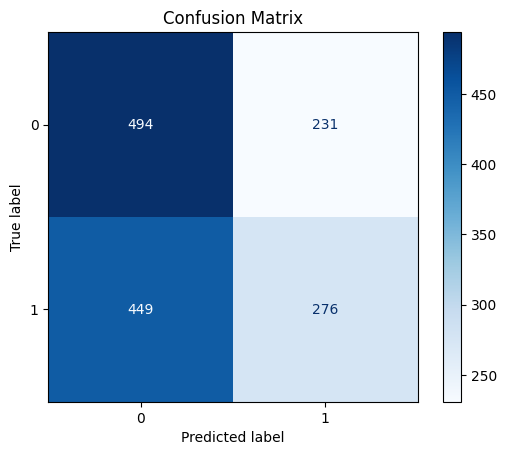


Gerando PDF com a visualização dos pares de validação...
Gerando PDF 'Pdf/analise_visual_pares_validacao.pdf' com 1450 pares...


100%|██████████| 1450/1450 [01:52<00:00, 12.86it/s]


✅ PDF 'Pdf/analise_visual_pares_validacao.pdf' gerado com sucesso!


In [15]:
def plot_pairs_with_scores_to_pdf(filename, left_images, right_images, scores, labels):
    """
    Plota pares de imagens lado a lado, com o score de dissimilaridade e o label verdadeiro no título,
    e salva todas as figuras em um único arquivo PDF.

    Args:
        filename (str): Nome do arquivo PDF a ser salvo.
        left_images (np.array): Array com as imagens do lado esquerdo.
        right_images (np.array): Array com as imagens do lado direito.
        scores (np.array): Array com os scores de dissimilaridade.
        labels (np.array): Array com os labels verdadeiros.
    """
    # Abre o arquivo PDF para escrita
    with PdfPages(filename) as pdf:
        # Itera sobre cada par de imagem, score e label
        # Usamos tqdm para ter uma barra de progresso, já que pode demorar
        print(f"Gerando PDF '{filename}' com {len(left_images)} pares...")
        for i in tqdm(range(len(left_images))):
            # Cria a figura e os eixos (1 linha, 2 colunas)
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            
            # --- Monta o título com as informações ---
            title = f"Par de Imagens #{i+1}\nDissimilaridade = {scores[i]:.4f} | Label Verdadeiro = {labels[i]}"
            fig.suptitle(title, fontsize=12)

            # --- Plota a imagem da esquerda ---
            # .squeeze() remove a dimensão do canal (de 40,40,1 para 40,40)
            axs[0].imshow(left_images[i].squeeze(), cmap='gray')
            axs[0].set_title("Lado Esquerdo")
            axs[0].axis('off') # Remove os eixos x e y

            # --- Plota a imagem da direita ---
            axs[1].imshow(right_images[i].squeeze(), cmap='gray')
            axs[1].set_title("Lado Direito (Flippado)")
            axs[1].axis('off')

            # Salva a figura atual como uma nova página no PDF
            pdf.savefig(fig)
            
            # Fecha a figura para liberar memória (MUITO IMPORTANTE!)
            plt.close(fig)
            
    print(f"✅ PDF '{filename}' gerado com sucesso!")

# Verificando a acurácia e a matriz de confusão com este limiar
y_pred_optimal = (dissimilarity_scores > optimal_threshold).astype(int)
plot_confusion_matrix(true_labels, y_pred_optimal)

print("\nGerando PDF com a visualização dos pares de validação...")
plot_pairs_with_scores_to_pdf(
    "Pdf/analise_visual_pares_validacao.pdf",
    left_images=valid_left_balanced,
    right_images=valid_right_balanced,
    scores=dissimilarity_scores,
    labels=true_labels
)

In [16]:
# Finaliza o wandb
wandb.finish()

#### Plotando PDFs para comparação dos resultados e análise das classificações

In [17]:
# Função para adicionar borda ao patch com a cor da classificação
def add_border(image, color, thickness=3):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    bordered_image = cv2.copyMakeBorder(image_rgb, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

def enhance_contrast(img, factor=1.1):
    img = img.astype(np.float32)
    img = img * factor
    return np.clip(img, 0, 255).astype(np.uint8)

# Função para carregar imagens no formato NIfTI (.nii.gz)
def load_nii_slice(patient_id, slice_index, base_path):
    file_path = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.nii.gz")
    if os.path.exists(file_path):
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()
        return img_data
    return None

# Função para carregar coordenadas de arquivos .txt
def load_coordinates(patient_id, slice_index, base_path):
    coord_file = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.txt")
    if os.path.exists(coord_file):
        with open(coord_file, "r") as file:
            coordinates = [tuple(map(int, line.strip().split(","))) for line in file]
        return coordinates
    return []

# Função para reconstruir a imagem e sobrepor o grid
def build_image_with_grid(patient_id, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)
    
    if img is None or mask is None or not coordinates:
        return None, None, index

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)

    reconstructed_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    
    half = len(coordinates) // 2
    classifications = []

    for i in range(half):
        true = labels_true[i + index]
        pred = labels_pred[i + index]
        if pred == true:
            classif = "TP" if pred == 1 else "TN"
        else:
            classif = "FP" if pred == 1 else "FN"
        classifications.append(classif)
    
    # Repetir a classificação para o lado direito
    classifications.extend(classifications)

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        classif = classifications[i]

        patch_img = img[y1+3:y2-3, x1+3:x2-3]
        patch_mask = mask[y1+3:y2-3, x1+3:x2-3]

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask, (index + half)

# Reconstrói uma fatia do paciente usando coordenadas + indexes mapeados
def build_image_with_grid_indexed(patient_id, slice_index, balanced_index_patients,
                                  labels_pred, labels_true, image_path, mask_path,
                                  coordinates_path, patch_metadata):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)

    if img is None or mask is None or not coordinates:
        return None, None

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)
    
    height, width = img.shape[:2]
    reconstructed_img = np.zeros((height, width, 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((height, width, 3), dtype=np.uint8)

    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        # Identifica o global_index da coordenada
        global_index = None
        for idx, meta in patch_metadata.items():
            if meta[0] == patient_id and meta[1] == slice_index and meta[3:] == (y1, y2, x1, x2):
                global_index = idx
                break

        if global_index in balanced_index_patients:
            label_pos = balanced_index_patients.index(global_index)
            true_label = labels_true[label_pos]
            pred_label = labels_pred[label_pos]

            if pred_label == true_label:
                classif = "TP" if pred_label == 1 else "TN"
            else:
                classif = "FP" if pred_label == 1 else "FN"

            patch_img = img[y1+3:y2-3, x1+3:x2-3]
            patch_mask = mask[y1+3:y2-3, x1+3:x2-3]
        else:
            classif = "TN"
            patch_img = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)
            patch_mask = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask

# Gera metadados global_index → (patient, slice, side, y1, y2, x1, x2)
def generate_patch_metadata(patients, coordinates_path):
    patch_metadata = {}
    global_index = 0
    for patient in patients:
        patient_dir = os.path.join(coordinates_path, patient)
        if not os.path.isdir(patient_dir):
            continue
        for filename in sorted(os.listdir(patient_dir)):
            if filename.endswith(".txt"):
                slice_index = int(filename.split("_")[1].split(".")[0])
                coord_file = os.path.join(patient_dir, filename)
                with open(coord_file, "r") as f:
                    coords = [tuple(map(int, line.strip().split(","))) for line in f if line.strip()]
                half = len(coords) // 2
                for i, (y1, y2, x1, x2) in enumerate(coords):
                    side = 'left' if i < half else 'right'
                    patch_metadata[global_index] = (patient, slice_index, side, y1, y2, x1, x2)
                    global_index += 1
    print(f"✅ Mapeamento gerado com {len(patch_metadata)} patches.")
    return patch_metadata


In [18]:
def plot_patient_slices(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-42B05': 1204, 'sub-42K06': 1122, 'sub-44H05': 1213, 'sub-86G08': 1189}
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Uppersampling+Undersampling.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

NameError: name 'y_pred_test' is not defined

In [ ]:
def plot_patches_patient_slices_with_borders_and_masks(
    pdf_folder, patients, image_left, image_right,
    mask_left, mask_right, labels_true, labels_pred
):
    os.makedirs(pdf_folder, exist_ok=True)

    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    index = 0

    for patient in patients:
        if patient not in image_left or patient not in image_right:
            print(f"❌ Paciente {patient} não encontrado nos dados.")
            continue

        num_patches = len(image_left[patient])
        patient_folder = os.path.join(pdf_folder, patient)
        os.makedirs(patient_folder, exist_ok=True)
        pdf_filename = os.path.join(patient_folder, f"Paciente_{patient}.pdf")

        with PdfPages(pdf_filename) as pdf:
            for i in range(num_patches):
                if index >= len(labels_true) or index >= len(labels_pred):
                    break

                true_label = labels_true[index]
                pred_label = labels_pred[index]
                if pred_label == true_label:
                    classif = "TP" if pred_label == 1 else "TN"
                else:
                    classif = "FP" if pred_label == 1 else "FN"
                color = colors[classif]

                patch_l = image_left[patient][i]
                patch_r = image_right[patient][i]
                mask_l = mask_left[patient][i]
                mask_r = mask_right[patient][i]

                patch_l_border = add_border(patch_l, color)
                patch_r_border = add_border(patch_r, color)
                mask_l_border = add_border(mask_l, color)
                mask_r_border = add_border(mask_r, color)

                fig, axs = plt.subplots(2, 2, figsize=(6, 6))
                axs[0, 0].imshow(patch_l_border)
                axs[0, 0].set_title("Esquerda")
                axs[0, 1].imshow(patch_r_border)
                axs[0, 1].set_title("Direita")
                axs[1, 0].imshow(mask_l_border)
                axs[1, 0].set_title("Másc. Esq.")
                axs[1, 1].imshow(mask_r_border)
                axs[1, 1].set_title("Másc. Dir.")

                for ax in axs.flat:
                    ax.axis("off")

                fig.suptitle(f"{patient} | {classif} | idx {index}", fontsize=10)
                pdf.savefig(fig)
                plt.close(fig)

                index += 1

        print(f"✅ PDF salvo: {pdf_filename}")

    print(f"\n📂 Todos os PDFs foram salvos em: {pdf_folder}")

plot_patches_patient_slices_with_borders_and_masks(
    pdf_folder="Pdf_final_patches_treino",
    patients=train_patients,
    image_left=train_left_balanced,
    image_right=train_right_balanced,
    mask_left=balanced_mask_left,
    mask_right=balanced_mask_right,
    labels_true=y_train_balanced,
    labels_pred=y_pred_train
)

plot_patches_patient_slices_with_borders_and_masks(
    pdf_folder="Pdf_final_patches_validacao",
    patients=valid_patients,
    image_left=valid_left_balanced,
    image_right=valid_right_balanced,
    mask_left=balanced_mask_left,
    mask_right=balanced_mask_right,
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid
)